<h1 style="font-size:3rem;color:orange;">Development of Mini Application of Indonesian Abusive Words Filter on Twitter with Stopword Removal Methods</h1>

- Analyze the character of the data
- Cleaning process of unnecessary data characters
- Analyze which data often appears
- Create a mini-app to perform character filtering on tweeters



In [1]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
sns.set(color_codes=True)
import sqlite3
import os.path

In [2]:
df = pd.read_csv('data.csv', encoding='latin-1') #data that will be analyzed

alay_dictionary = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None) #data "alay dictionary"
alay_dictionary = alay_dictionary.rename(columns={0: 'original', 
                                      1: 'replacement'}) 

d_abusive = pd.read_csv('abusive.csv', encoding='latin-1', header=None) #data abusive.
d_abusive = d_abusive.rename(columns={0: 'abusive'}) 


d_stopword1 = pd.read_csv('stopwordbahasa.csv', header=None) #data stop word.
d_stopword1 = d_stopword1.rename(columns={0: 'stopword'})
stopwords_new = pd.DataFrame(['sih','nya', 'iya', 'nih', 'biar', 'tau', 'kayak', 'banget'], columns=['stopword'])
d_stopword1 = pd.concat([d_stopword1,stopwords_new]).reset_index()
d_stopword1 = pd.DataFrame(d_stopword1['stopword'])

In [3]:
df.shape

(13169, 13)

In [4]:
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


Calculating Hatespeech based on its Rudeness level

In [5]:
df.HS_Strong.value_counts()

0    12696
1      473
Name: HS_Strong, dtype: int64

In [6]:
df.HS_Moderate.value_counts()

0    11464
1     1705
Name: HS_Moderate, dtype: int64

In [7]:
df.HS_Weak.value_counts()

0    9786
1    3383
Name: HS_Weak, dtype: int64

Counting Hatespeech by Type

In [8]:
df.HS_Individual.value_counts()

0    9594
1    3575
Name: HS_Individual, dtype: int64

In [9]:
df.HS_Group.value_counts()

0    11183
1     1986
Name: HS_Group, dtype: int64

In [10]:
df.HS_Religion.value_counts()

0    12376
1      793
Name: HS_Religion, dtype: int64

In [11]:
df.HS_Race.value_counts()

0    12603
1      566
Name: HS_Race, dtype: int64

In [12]:
df.HS_Physical.value_counts()# 

0    12846
1      323
Name: HS_Physical, dtype: int64

In [13]:
df.HS_Gender.value_counts()

0    12863
1      306
Name: HS_Gender, dtype: int64

In [14]:
df.HS_Other.value_counts()

0    9429
1    3740
Name: HS_Other, dtype: int64

Toxic word count and Non-Toxic

In [15]:
df.HS.value_counts() 

0    7608
1    5561
Name: HS, dtype: int64

In [16]:
df.Abusive.value_counts()#counting rude tweets

0    8126
1    5043
Name: Abusive, dtype: int64

In [17]:
print("Toxic : ", df[(df['HS'] == 1) & (df['Abusive'] == 1)].shape) #counting toxic and non-toxic tweets
print("Non-toxic : ", df[(df['HS'] == 0) & (df['Abusive'] == 0)].shape)

Toxic :  (3295, 13)
Non-toxic :  (5860, 13)


In [50]:
print("Shape: ", alay_dictionary.shape) #count data from the word "alay"
alay_dictionary.tail(5)

Shape:  (15167, 2)


,original,replacement
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit
15166,megangin,memegang


In [23]:
print("Shape: ", d_stopword1.shape) #counts stopword data
d_stopword1.head(6)

Shape:  (772, 1)


,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak
5,agaknya


In [24]:
print("Shape: ", d_abusive.shape) #counts stopword data
d_abusive.head(6)

Shape:  (132, 1)


,abusive
0,ABUSIVE
1,alay
2,ampas
3,buta
4,keparat
5,anjing


Text cleaning processing 

In [25]:
import re
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove '\n'
    text = re.sub('rt',' ',text) # Remove retweet symbol
    text = re.sub('user',' ',text) # Username omitted
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove URL
    text = re.sub('  +', ' ', text) # Extra spaces removed
    return text

In [26]:
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

In [27]:
alay_dict_map = dict(zip(alay_dictionary['original'], alay_dictionary['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])
#Replace the word "alay" with a standard wordy

def remove_abusive(text):
    text = ' '.join(['' if word in d_abusive.abusive.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stopword_remover(text):
    text = ' '.join(['' if word in d_stopword1.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("SELAMATT PAGIII,,,, duniaa!!"))
print("lowercase: ", lowercase("selamatt pagiii,,,, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))
print("remove_abusive: ", remove_abusive("cebong anjing suka makan tai"))
print("stop_word_remover: ", stopword_remover("kami dan keluarga senang mengajak anjing jalan jalan"))




remove_nonaplhanumeric:  SELAMATT PAGIII duniaa 
lowercase:  selamatt pagiii,,,, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe
normalize_alay:  amin adik habis
remove_abusive:  suka makan
stop_word_remover:  keluarga senang mengajak anjing jalan jalan


In [28]:
def preprocess(text):
    text = lowercase(text) # 1 Replacing capital letters with lowercase letters
    text = remove_nonaplhanumeric(text) # 2 Removes all characters other than alphabets
    text = remove_unnecessary_char(text) # 3 Remove unnecessary characters
    text = normalize_alay(text) # 4 Eliminate "alay" words, and replace them with standard words.
    text = remove_abusive(text) # 5 Eliminate abusive words
    return text

In [29]:
df['Tweet'] = df['Tweet'].apply(preprocess) # the logic of the mini aps is finished

In [30]:
print("Shape: ", df.shape)
df.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,di saat semua cowok berusaha melacak perhatian...,1,1,1,0,0,0,0,0,1,1,0,0
1,siapa yang telat memberi tau kamu gue bergaul ...,0,1,0,0,0,0,0,0,0,0,0,0
2,41 kadang aku berpikir kenapa aku tetap percay...,0,0,0,0,0,0,0,0,0,0,0,0
3,aku itu aku dan ku tau matamu tapi dilihat dar...,0,0,0,0,0,0,0,0,0,0,0,0
4,kaum sudah kelihatan dongoknya dari awal tamba...,1,1,0,1,1,0,0,0,0,0,1,0


In [31]:
def preprocess(text):
    text = lowercase(text) # 1 Replacing capital letters with lowercase letters
    text = remove_nonaplhanumeric(text) # 2 Removes all characters other than alphabets
    text = remove_unnecessary_char(text) # 3 Remove unnecessary characters
    text = normalize_alay(text) # 4 Eliminate swear words, and replace them with standard words.
    text = remove_abusive(text) # 5 Eliminate abusive words
    text = stopword_remover(text) # 6 Remove stopwords in tweets
    return text

In [32]:
df['Tweet'] = df['Tweet'].apply(preprocess)

In [33]:
print("Shape: ", df.shape)
df.head(5)

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,cowok berusaha melacak perhatian gue lantas re...,1,1,1,0,0,0,0,0,1,1,0,0
1,telat gue bergaul cigax jifla calis licew,0,1,0,0,0,0,0,0,0,0,0,0
2,41 kadang berpikir percaya tuhan jatuh berkali...,0,0,0,0,0,0,0,0,0,0,0,0
3,ku matamu,0,0,0,0,0,0,0,0,0,0,0,0
4,kaum dongoknya haha,1,1,0,1,1,0,0,0,0,0,1,0


Data visualization using WordCloud

In [34]:
df.to_csv('clean_data.csv', index=False)

In [51]:
import sqlite3
conn = sqlite3.connect('normalisasi_tweet.db')

In [52]:
df.to_sql('data_tweet', conn, if_exists='replace',index=False)
conn.close()
tweet_norm = pd.DataFrame(df)
tweet_norm.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,cowok berusaha melacak perhatian gue lantas re...,1,1,1,0,0,0,0,0,1,1,0,0
1,telat gue bergaul cigax jifla calis licew,0,1,0,0,0,0,0,0,0,0,0,0
2,41 kadang berpikir percaya tuhan jatuh berkali...,0,0,0,0,0,0,0,0,0,0,0,0
3,ku matamu,0,0,0,0,0,0,0,0,0,0,0,0
4,kaum dongoknya haha,1,1,0,1,1,0,0,0,0,0,1,0


In [53]:
conn = sqlite3.connect('normalisasi_tweet.db')

query = ''' SELECT * FROM data_tweet '''

taxis_df = pd.read_sql_query(query, conn)
taxis_df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,cowok berusaha melacak perhatian gue lantas re...,1,1,1,0,0,0,0,0,1,1,0,0
1,telat gue bergaul cigax jifla calis licew,0,1,0,0,0,0,0,0,0,0,0,0
2,41 kadang berpikir percaya tuhan jatuh berkali...,0,0,0,0,0,0,0,0,0,0,0,0
3,ku matamu,0,0,0,0,0,0,0,0,0,0,0,0
4,kaum dongoknya haha,1,1,0,1,1,0,0,0,0,0,1,0


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/wordcloud_image.png'

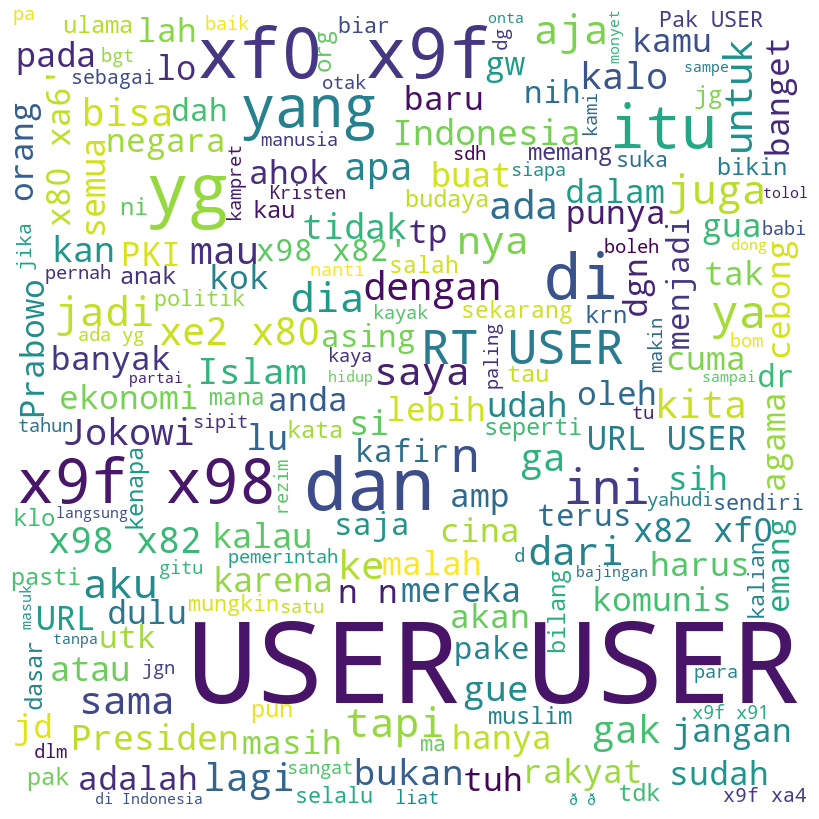

In [35]:
# Load the text data
text_data = open("data.csv", "r").read()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS).generate(text_data)

# Plot the WordCloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Save the WordCloud image
plt.savefig("path/to/wordcloud_image.png", bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/wordcloud_image.png'

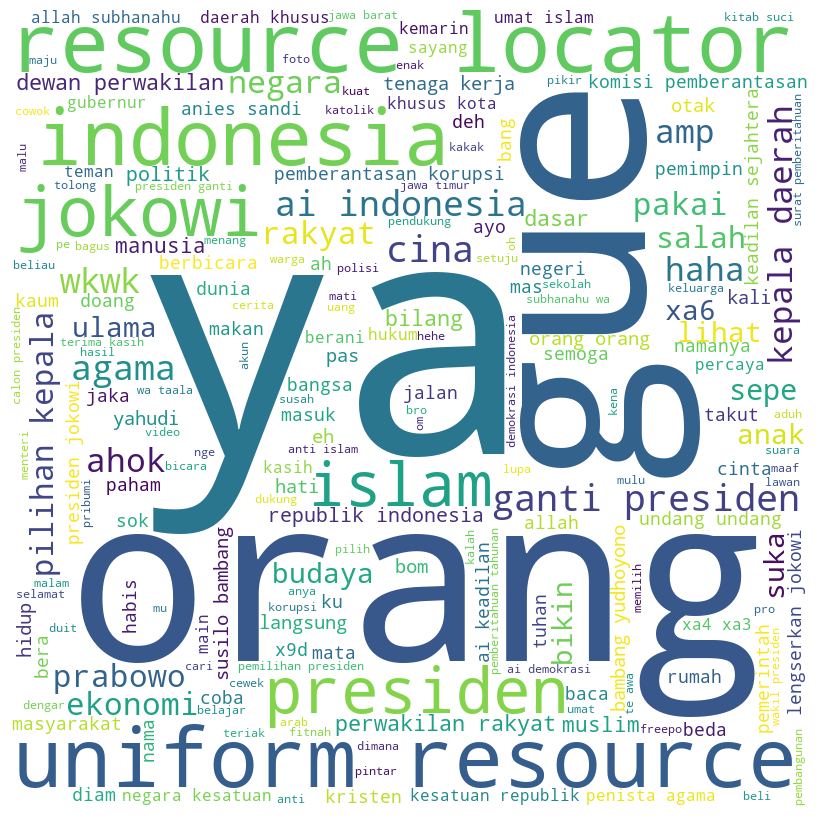

In [36]:
# Load the text data
text_data = open("clean_data.csv", "r").read()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS).generate(text_data)

# Plot the WordCloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Save the WordCloud image
plt.savefig("path/to/wordcloud_image.png", bbox_inches='tight')

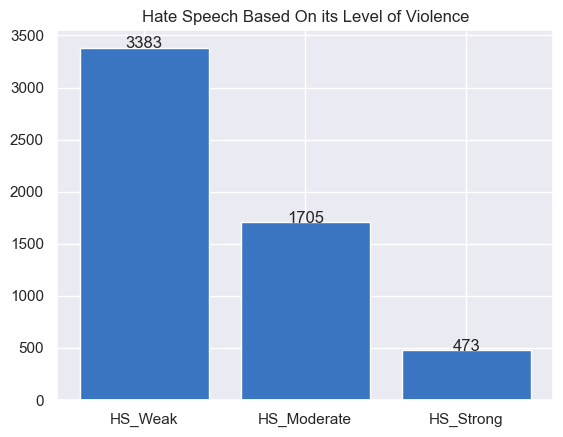

In [46]:
x_labels = ['HS_Weak', 'HS_Moderate','HS_Strong']
y_values = [3383, 1705, 473]
colors = ['#3a75c2']
x_pos = np.arange(len(x_labels))
plt.bar(x_pos, y_values, color=colors)
for i, value in enumerate(y_values):
    plt.text(i, value + 1, str(value), ha='center')
plt.xticks(x_pos, x_labels, rotation=0)
plt.title('Hate Speech Based On its Level of Violence')
plt.show()

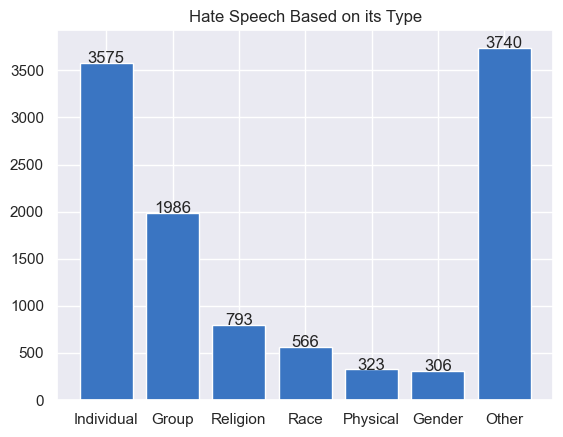

In [47]:
x_labels = ['Individual', 'Group', 'Religion','Race','Physical','Gender','Other']
y_values = [3575, 1986, 793, 566, 323, 306, 3740]
colors = ['#3a75c2']
x_pos = np.arange(len(x_labels))
plt.bar(x_pos, y_values, color=colors)
for i, value in enumerate(y_values):
    plt.text(i, value + 1, str(value), ha='center')
plt.xticks(x_pos, x_labels, rotation=0)
plt.title('Hate Speech Based on its Type')
plt.show()

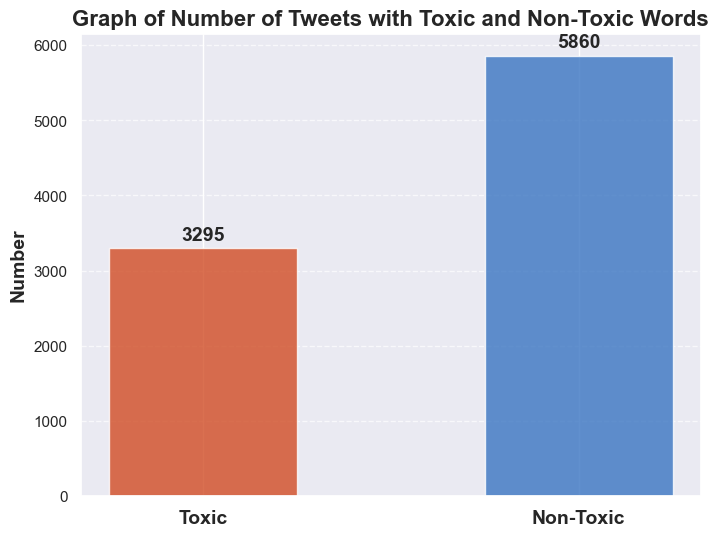

In [48]:
labels = ['Toxic', 'Non-Toxic']
data = [3295, 5860]

fig, ax = plt.subplots(figsize=(8,6))
x = np.arange(len(labels))
width = 0.5

rects = ax.bar(x, data, width, color=['#d14c24', '#3a75c2'], alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14, fontweight='bold')
ax.set_ylabel('Number', fontsize=14, fontweight='bold')
ax.set_title('Graph of Number of Tweets with Toxic and Non-Toxic Words', fontsize=16, fontweight='bold')

for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=14, fontweight='bold')


ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

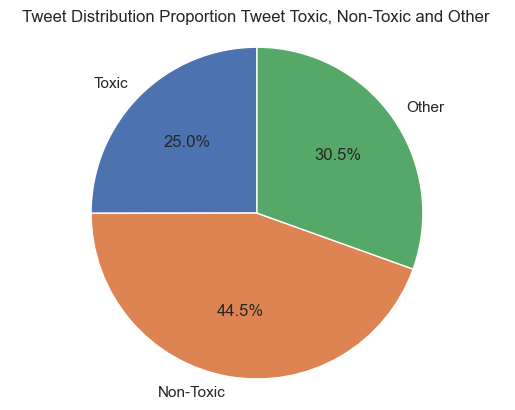

In [49]:
labels = ['Toxic', 'Non-Toxic', 'Other']
sizes = [3295, 5860, 4014]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title('Tweet Distribution Proportion Tweet Toxic, Non-Toxic and Other ')
plt.show()